# Correlation between the historical context and dominant emotions

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import pickle

sns.set_style('darkgrid')

In [8]:
DATA_PATH = "../../../data/emotions_interpolated_20.pkl"
DATA_PATH_FILM = "../../../data/final_dataset.pkl"


In [9]:
with open(DATA_PATH, 'rb') as f:
    df = pickle.load(f)
df.head(2)

with open(DATA_PATH_FILM, 'rb') as f:
    df_film = pickle.load(f)
df_countries = df_film[["Wikipedia_movie_ID", "Movie_countries","continent","category","Movie_release_date"]]
df_countries.head(10)

Wikipedia_movie_ID                           Movie_countries  \
1                 3333                  United States of America   
2                 3746       United States of America, Hong Kong   
3                 3837                  United States of America   
4                 3947                  United States of America   
5                 4227  United States of America, United Kingdom   
6                 4231                  United States of America   
7                 4560                  United States of America   
8                 4726  United States of America, United Kingdom   
9                 4728  United States of America, United Kingdom   
10                4729  United States of America, United Kingdom   

        continent                                           category  \
1   North America                          [Action/Adventure, Drama]   
2   North America                  [Drama, Fantasy/Sci-Fi, Thriller]   
3   North America                         [Action/Adventure, Comedy]   
4   North America                                         [Thriller]   
5   North America                                   [Drama, Romance]   
6   North America                 [Action/Adventure, Comedy, Horror]   
7   North America                          [Action/Adventure, Drama]   
8   North America                [Action/Adventure, Drama, Thriller]   
9   North America       [Action/Adventure, Fantasy/Sci-Fi, Thriller]   
10  North America  [Action/Adventure, Comedy, Fantasy/Sci-Fi, Thr...   

    Movie_release_date  
1                  NaN  
2               1982.0  
3               1974.0  
4                  NaN  
5               1975.0  
6               1992.0  
7               1995.0  
8               1989.0  
9               1992.0  
10              1997.0

In [10]:
df_merged = pd.merge(df, df_countries, on="Wikipedia_movie_ID", how="inner")
df_merged.set_index("Wikipedia_movie_ID", inplace=True)

# Normalize emotion scores
emotion_columns = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
#df_merged[emotion_columns] = df_merged[emotion_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
# Explode the "category" column to separate rows if a movie has multiple categories
df_exploded = df_merged.explode("category")
# Group by "continent", "category", and "timestep" to analyze emotions by continent and genre over time
df_groupy_by_continent = df_exploded.groupby(["continent", "category", "timestep"])[emotion_columns].mean()


In [11]:
# Assign individual DataFrames to variables for each continent for easy access
africa_df =  df_groupy_by_continent.xs('Africa', level='continent')
asia_df = df_groupy_by_continent.xs('Asia', level='continent')
europe_df = df_groupy_by_continent.xs('Europe', level='continent')
na_df = df_groupy_by_continent.xs('North America', level='continent')
oceania_df = df_groupy_by_continent.xs('Oceania', level='continent')
sa_df = df_groupy_by_continent.xs('South America', level='continent')

# Create a list containing all the continent-specific DataFrames for convenience
dfs = [africa_df, asia_df, europe_df, na_df, oceania_df, sa_df]

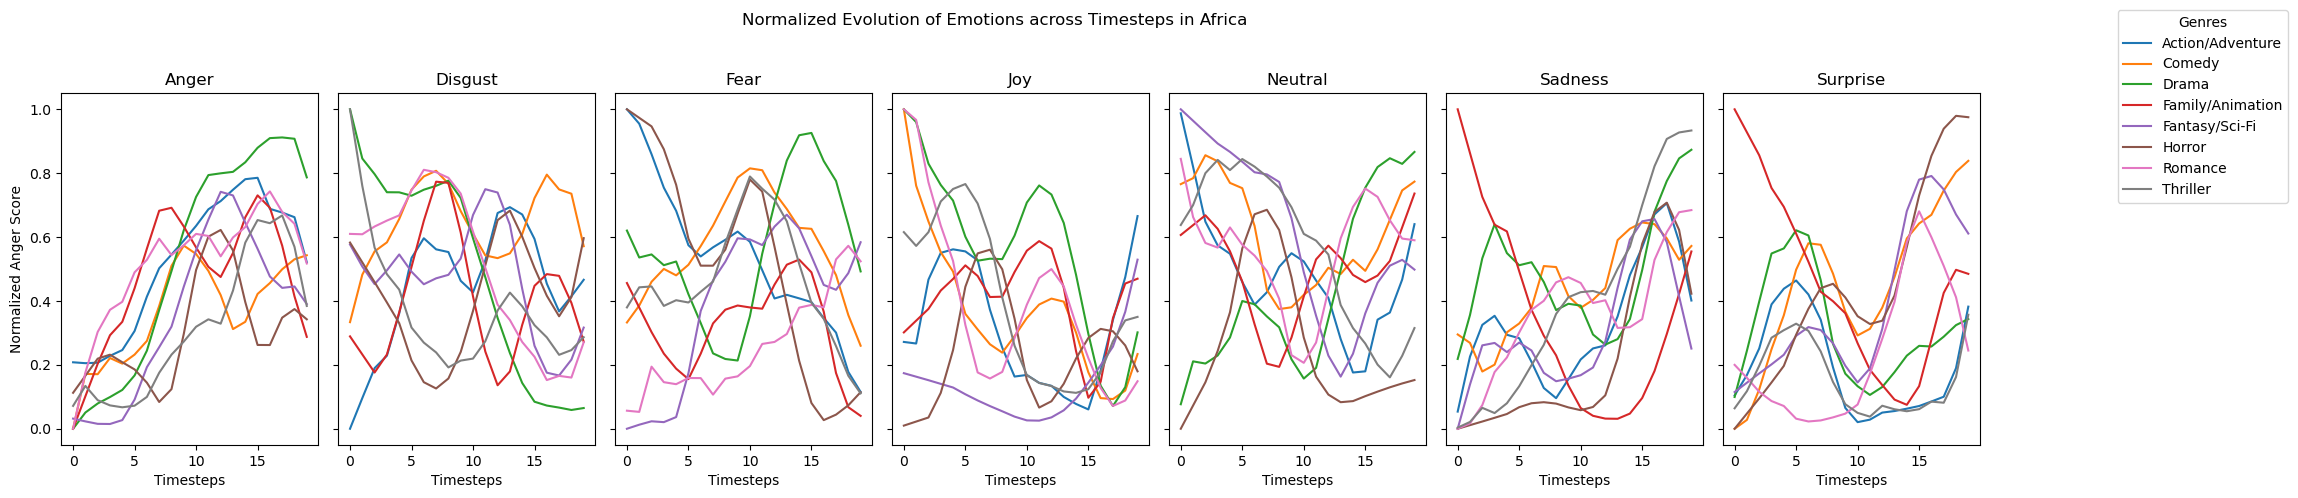

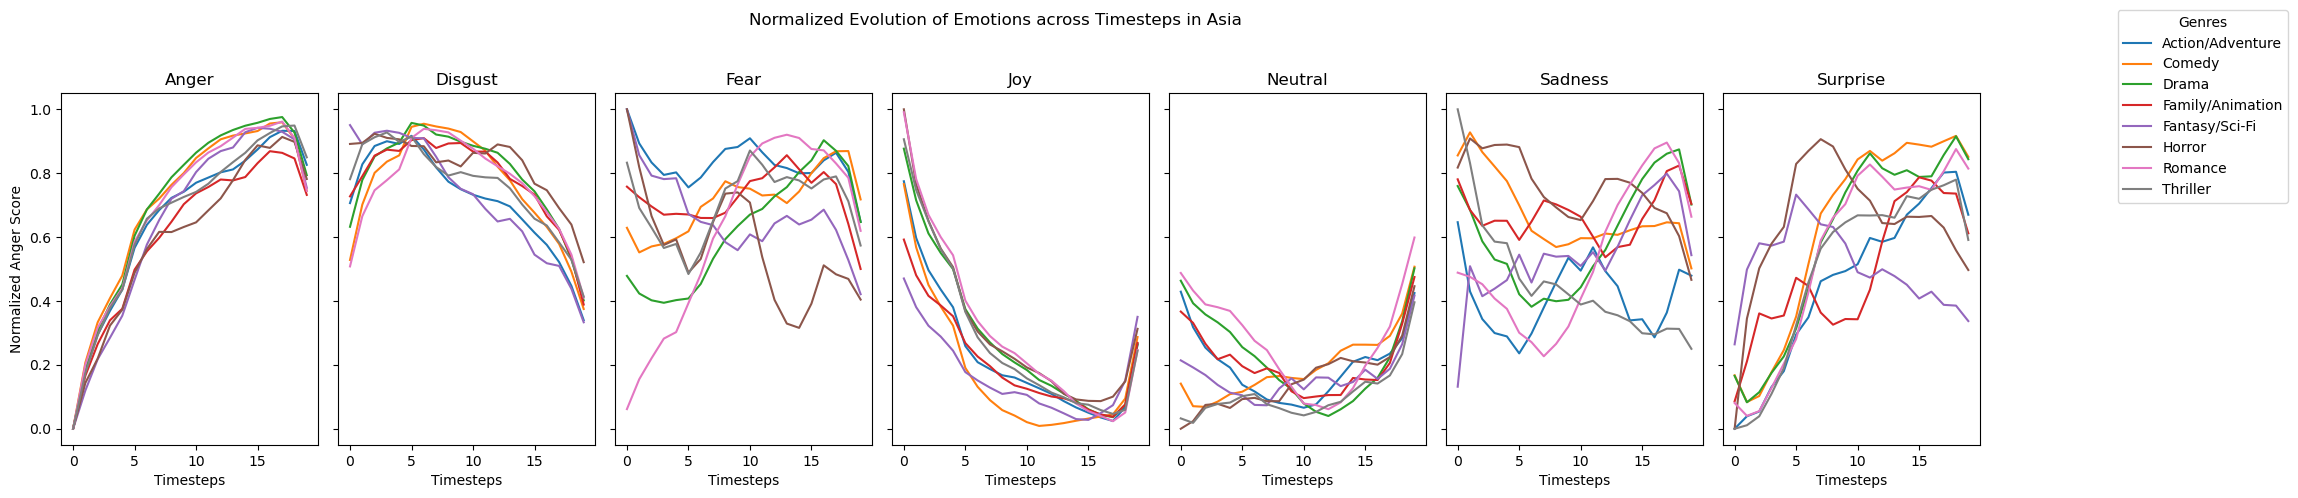

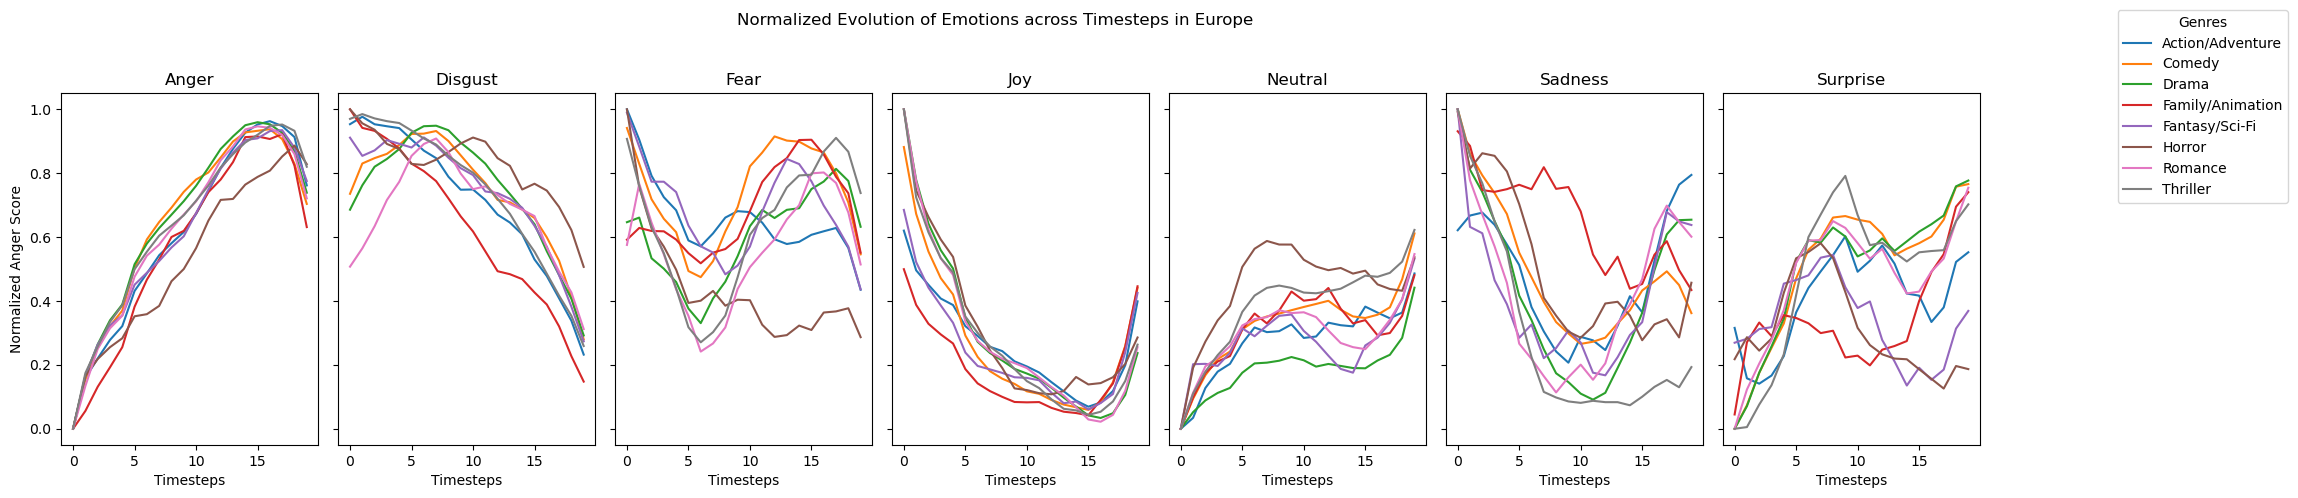

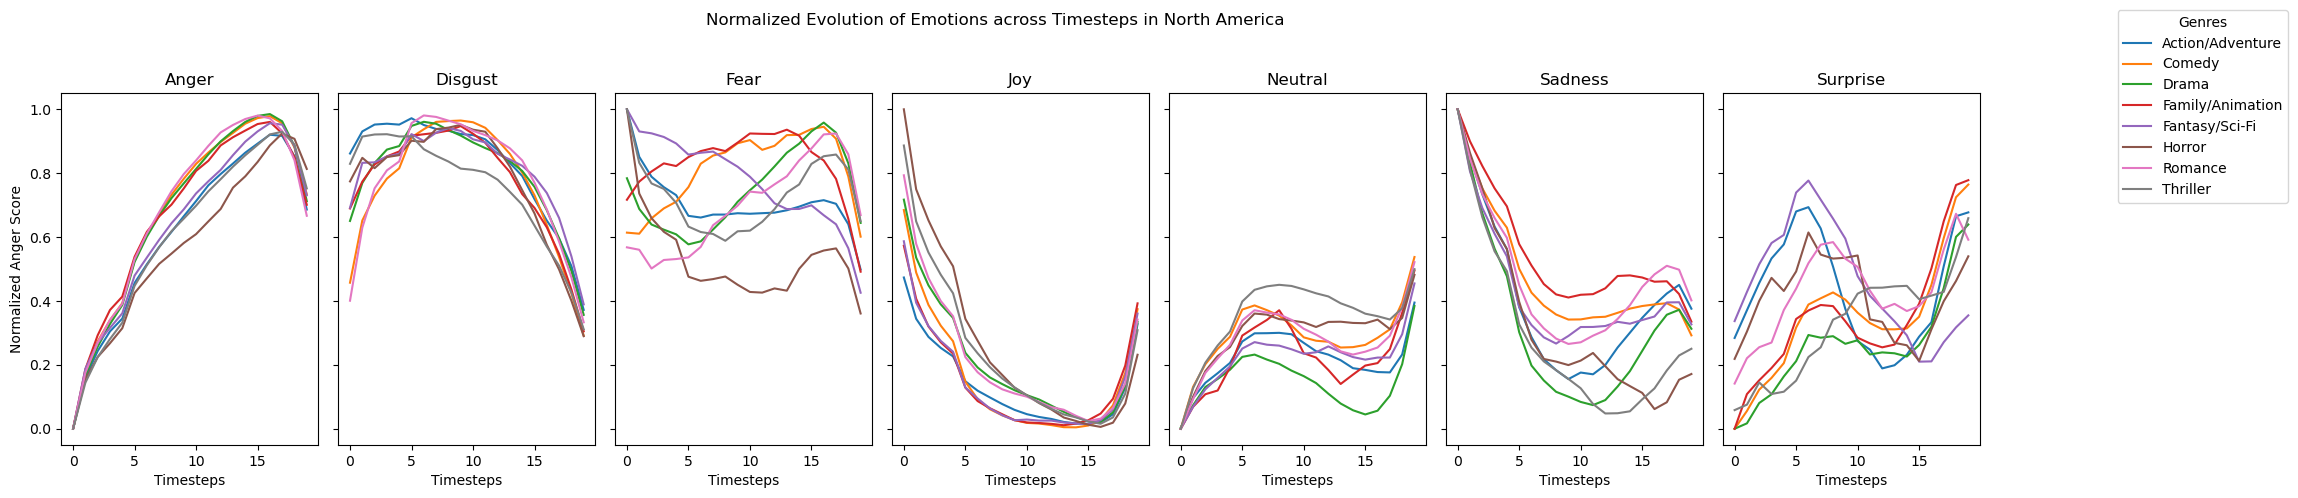

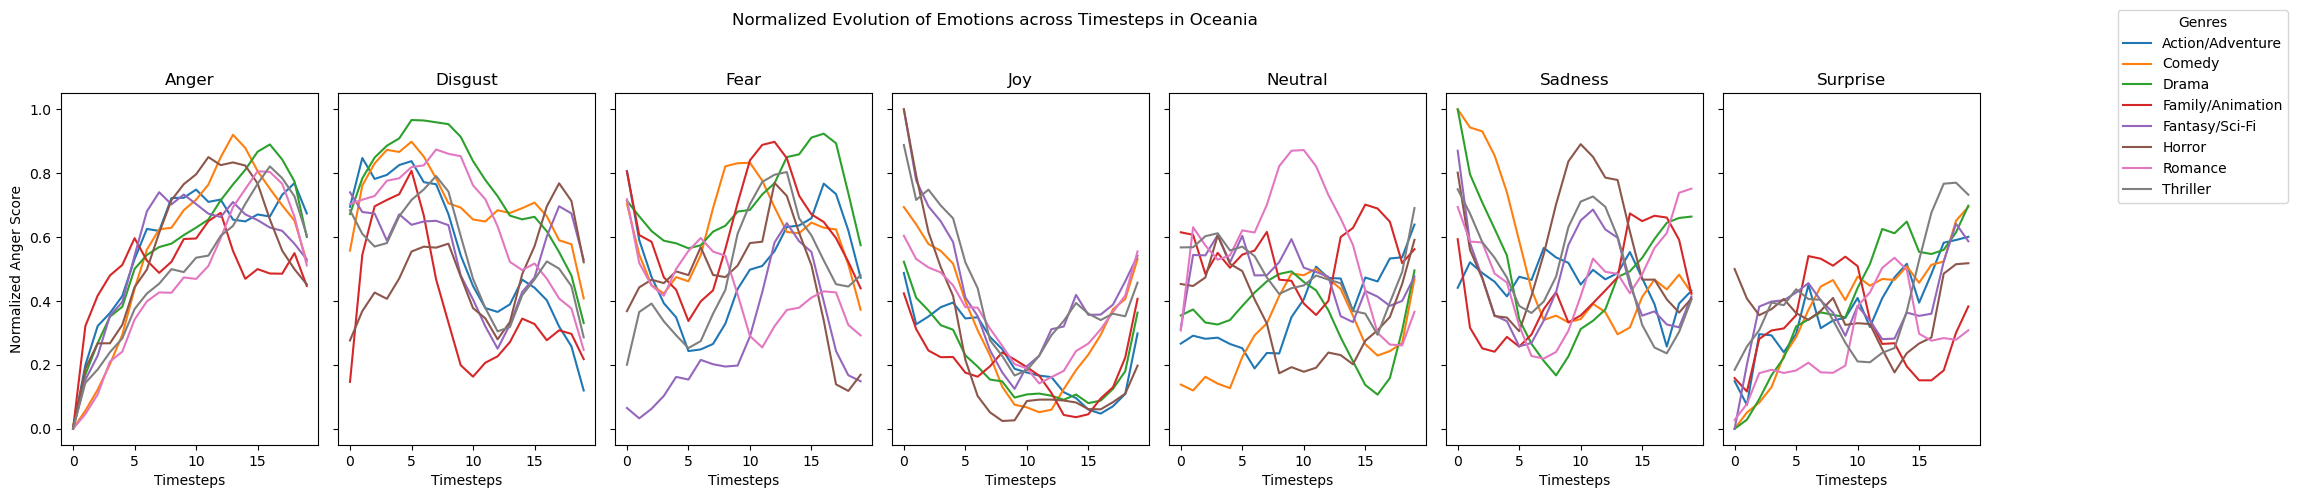

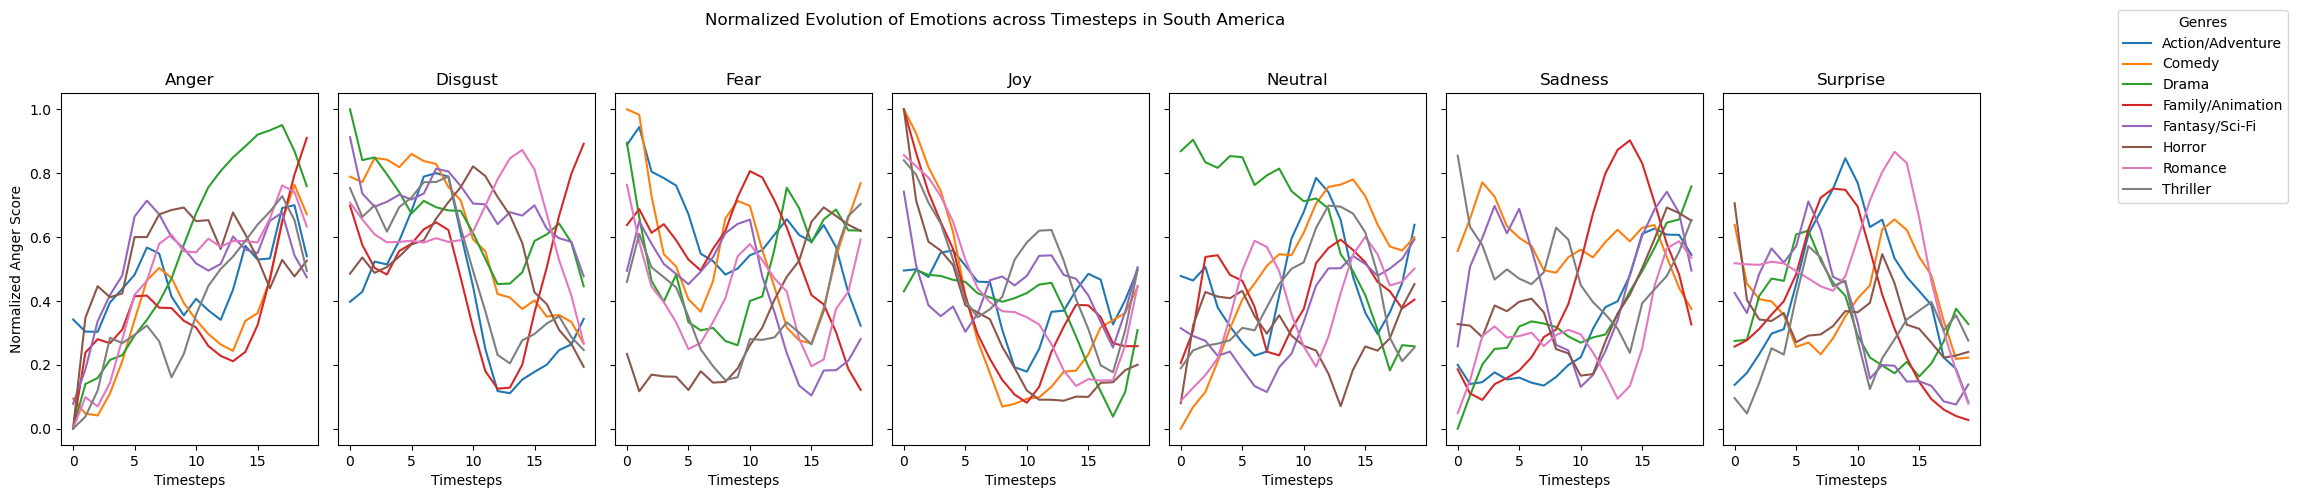

In [12]:
for continent_name, df_continent in zip(continents, dfs):
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps in {continent_name}")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_continent[emotion].unstack(level=0)

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()
        
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns)) 
        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

## Analysis of the Sentiment Arc Before and After Silent Films

#### We'll first focus on the US, the before is gonna be all the movie before 1925 and teh after is only gonna be from 1930 till 1940 to avoid taking the impact of WW2. The colour also appeared it movies around that time, more precisly in 1922.

In [ ]:
df_usa = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_usa.shape[0]/20)

df_before_1925 = df_usa[df_usa["Movie_release_date"] < 1922]


# Filter for movies released between 1930 and 1940
df_1930_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1930) & 
    (df_usa["Movie_release_date"] <= 1940)
]

count_before_1925 = df_usa[df_usa["Movie_release_date"] < 1922].shape[0]
count_1930_1940 = df_usa[(df_usa["Movie_release_date"] >= 1930) & (df_usa["Movie_release_date"] <= 1940)].shape[0]

print(f"Raw count of movies before 1922: {count_before_1925/20}")
print(f"Raw count of movies between 1930 and 1940: {count_1930_1940/20}")

df_before_1925 = df_before_1925.explode("category")
df_1930_1940 = df_1930_1940.explode("category")

df_before_1925 = df_before_1925.groupby(["category", "timestep"])[emotion_columns].mean()
df_1930_1940 = df_1930_1940.groupby(["category", "timestep"])[emotion_columns].mean()




18719.0
Raw count of movies before 1925: 421.0
Raw count of movies between 1930 and 1940: 1121.0


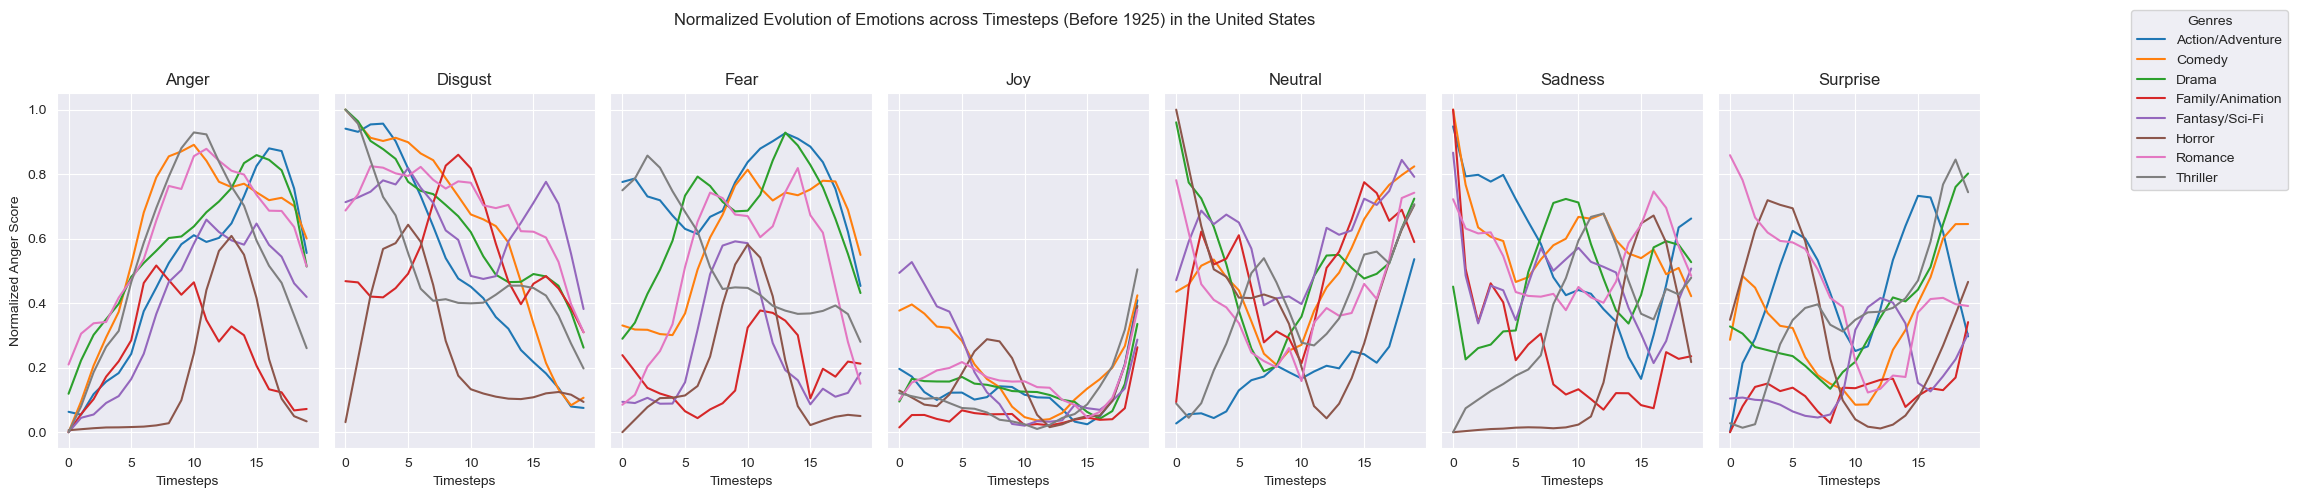

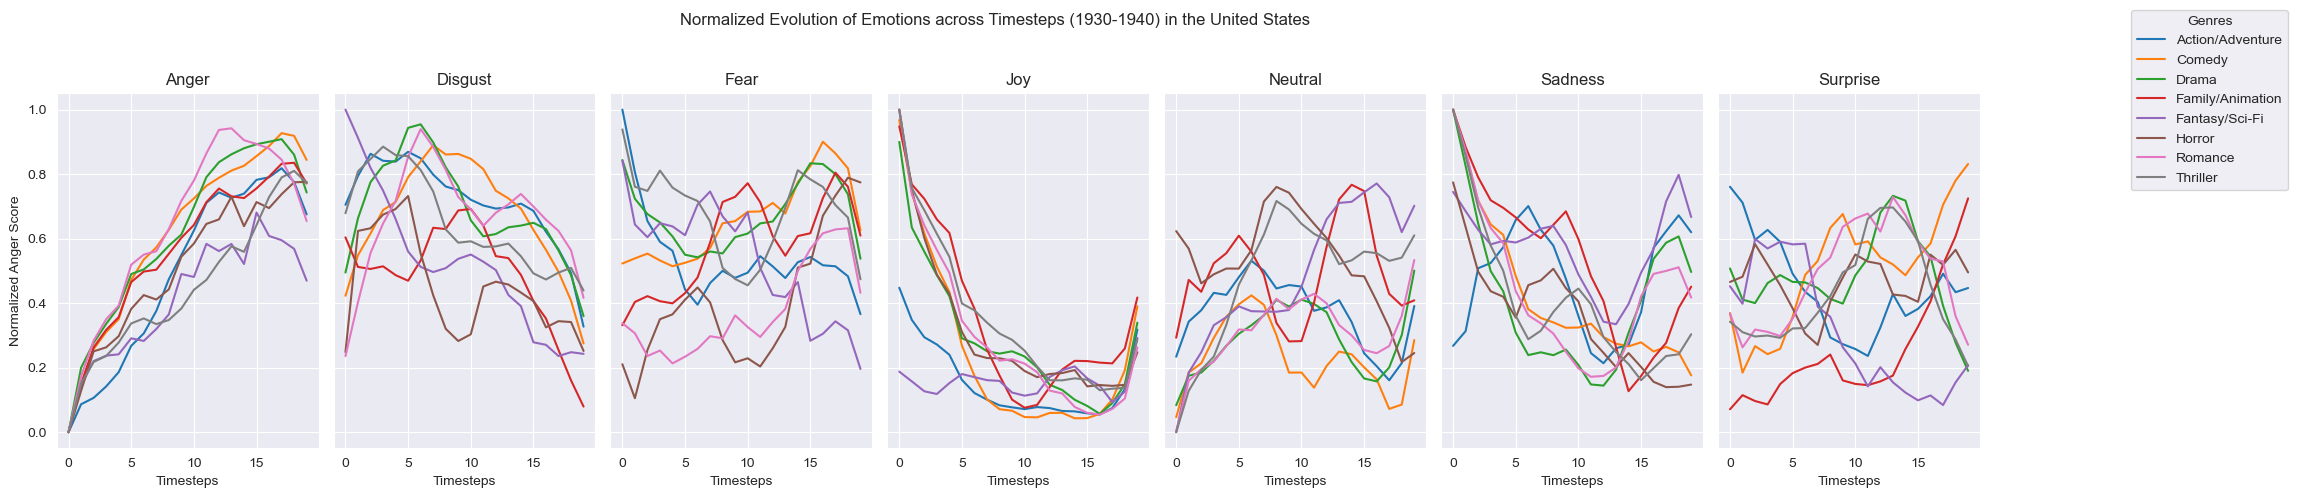

In [25]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1925": df_before_1925,
    "1930-1940": df_1930_1940
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



In [21]:
df_usa = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_usa.shape[0]/20)

df_before_1925 = df_usa[df_usa["Movie_release_date"] < 1925]


# Filter for movies released between 1930 and 1940
df_1930_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1925) & 
    (df_usa["Movie_release_date"] <= 1940)
]

count_before_1925 = df_usa[df_usa["Movie_release_date"] < 1925].shape[0]
count_1930_1940 = df_usa[(df_usa["Movie_release_date"] >= 1925) & (df_usa["Movie_release_date"] <= 1940)].shape[0]

print(f"Raw count of movies before 1925: {count_before_1925/20}")
print(f"Raw count of movies between 1930 and 1940: {count_1930_1940/20}")

df_before_1925 = df_before_1925.explode("category")
df_1930_1940 = df_1930_1940.explode("category")

df_before_1925 = df_before_1925.groupby(["category", "timestep"])[emotion_columns].mean()
df_1930_1940 = df_1930_1940.groupby(["category", "timestep"])[emotion_columns].mean()




18719.0
Raw count of movies before 1925: 539.0
Raw count of movies between 1930 and 1940: 1353.0


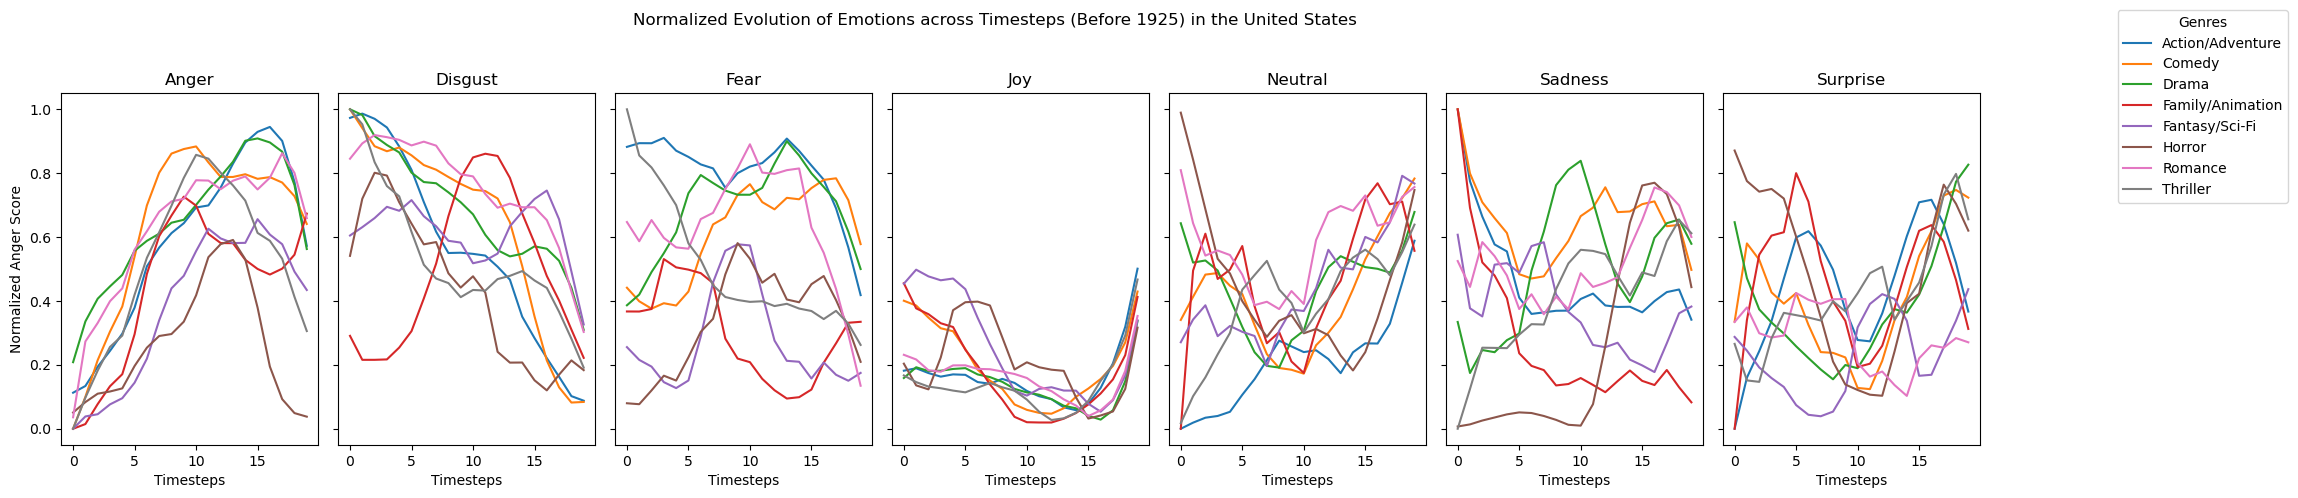

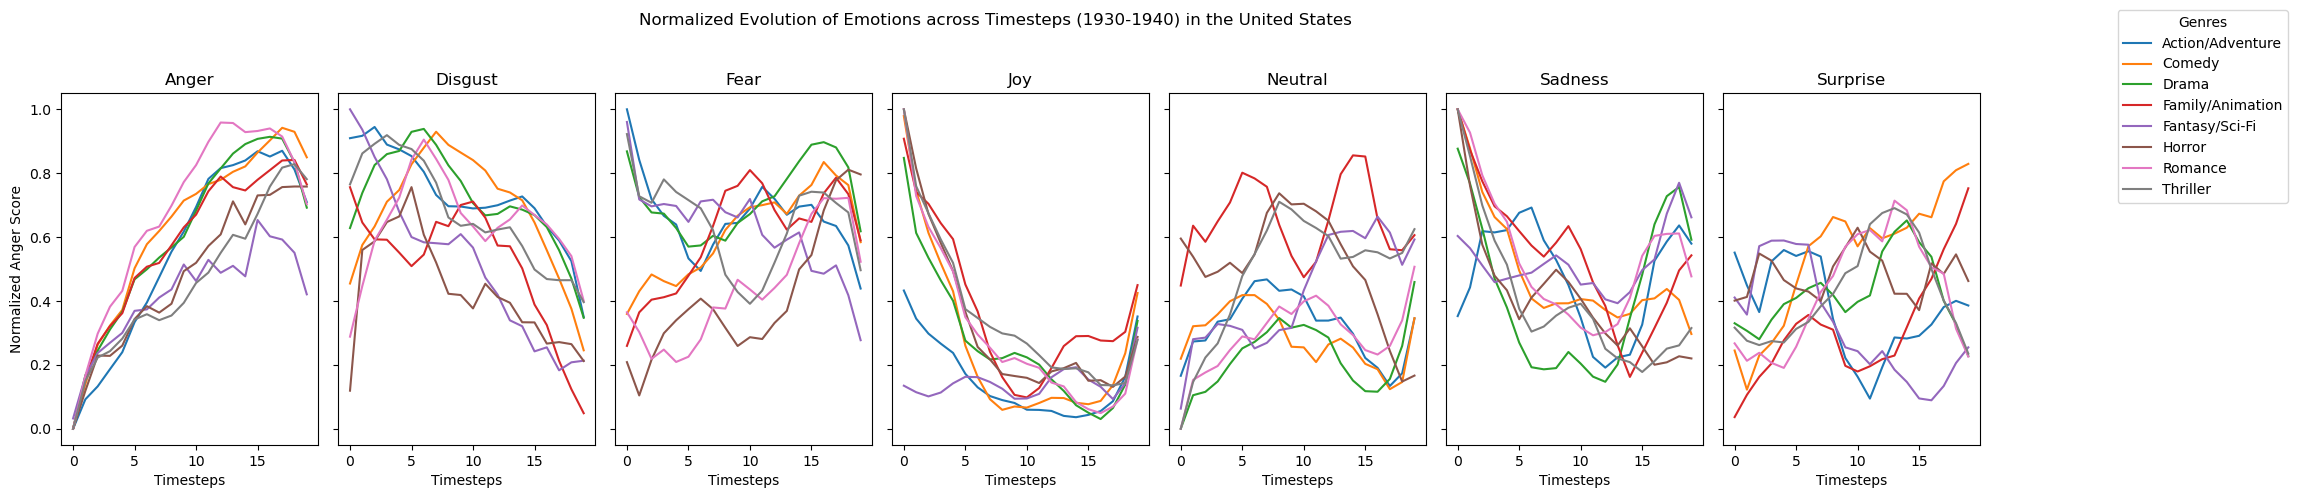

In [22]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1925": df_before_1925,
    "1930-1940": df_1930_1940
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



bcp plus de joy au debtut du film

## Before and after WW1

In [22]:
df_WW1 = df_merged
#[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_WW1.shape[0]/20)

df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1914]


# Filter for movies released between 1930 and 1940
df_1914_1925 = df_WW1[
    (df_WW1["Movie_release_date"] >= 1914) & 
    (df_WW1["Movie_release_date"] <= 1925)
]

count_df_before_1914 = df_WW1[df_WW1["Movie_release_date"] < 1915].shape[0]
count_df_1914_1925 = df_WW1[(df_WW1["Movie_release_date"] >= 1915) & (df_WW1["Movie_release_date"] <= 1925)].shape[0]

print(f"Raw count of movies before 1914: {count_df_before_1914/20}")
print(f"Raw count of movies between 1914 and 1925: {count_df_1914_1925/20}")

df_before_1914 = df_before_1914.explode("category")
df_1914_1925 = df_1914_1925.explode("category")

df_before_1914 = df_before_1914.groupby(["category", "timestep"])[emotion_columns].mean()
df_1914_1925 = df_1914_1925.groupby(["category", "timestep"])[emotion_columns].mean()

34342.0
Raw count of movies before 1914: 138.0
Raw count of movies between 1914 and 1925: 524.0


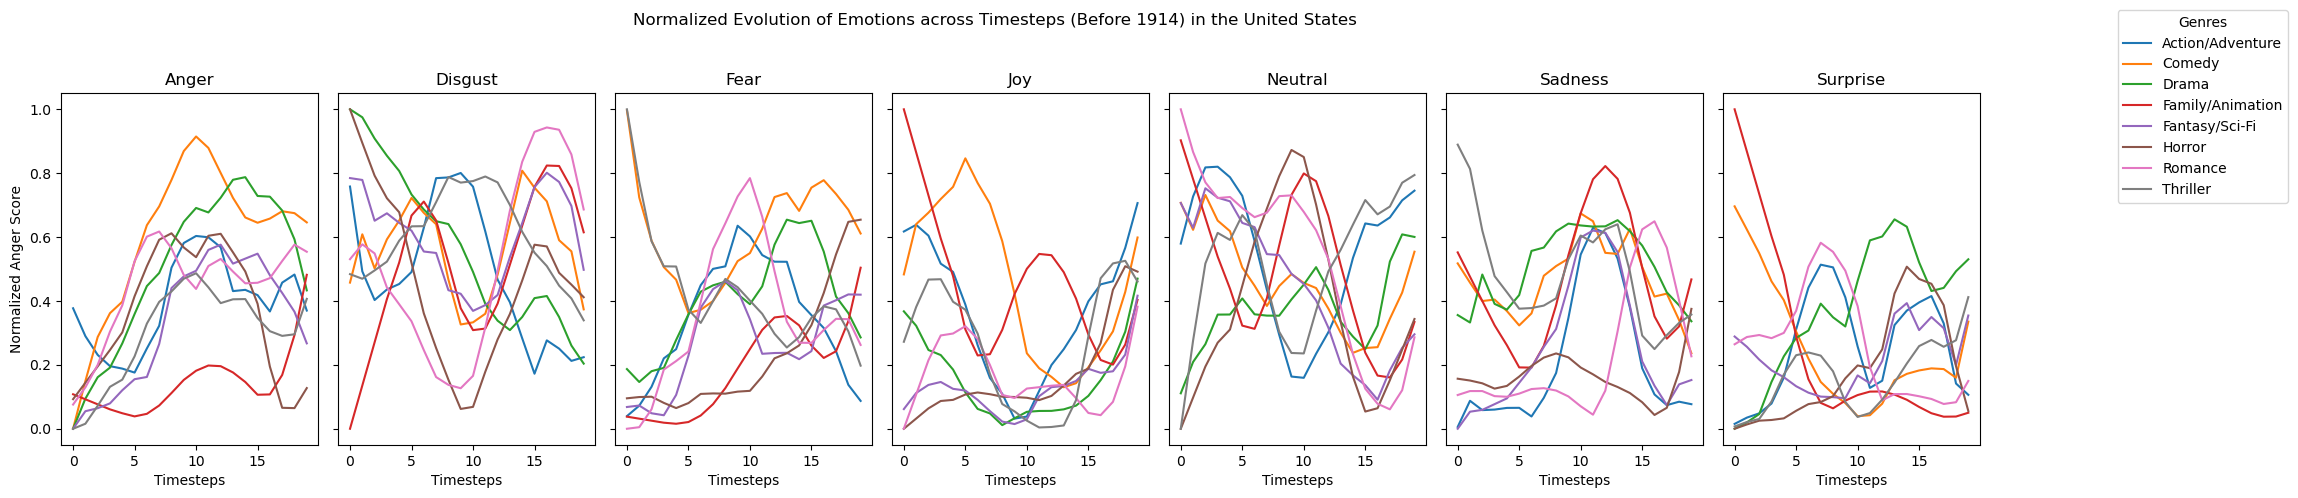

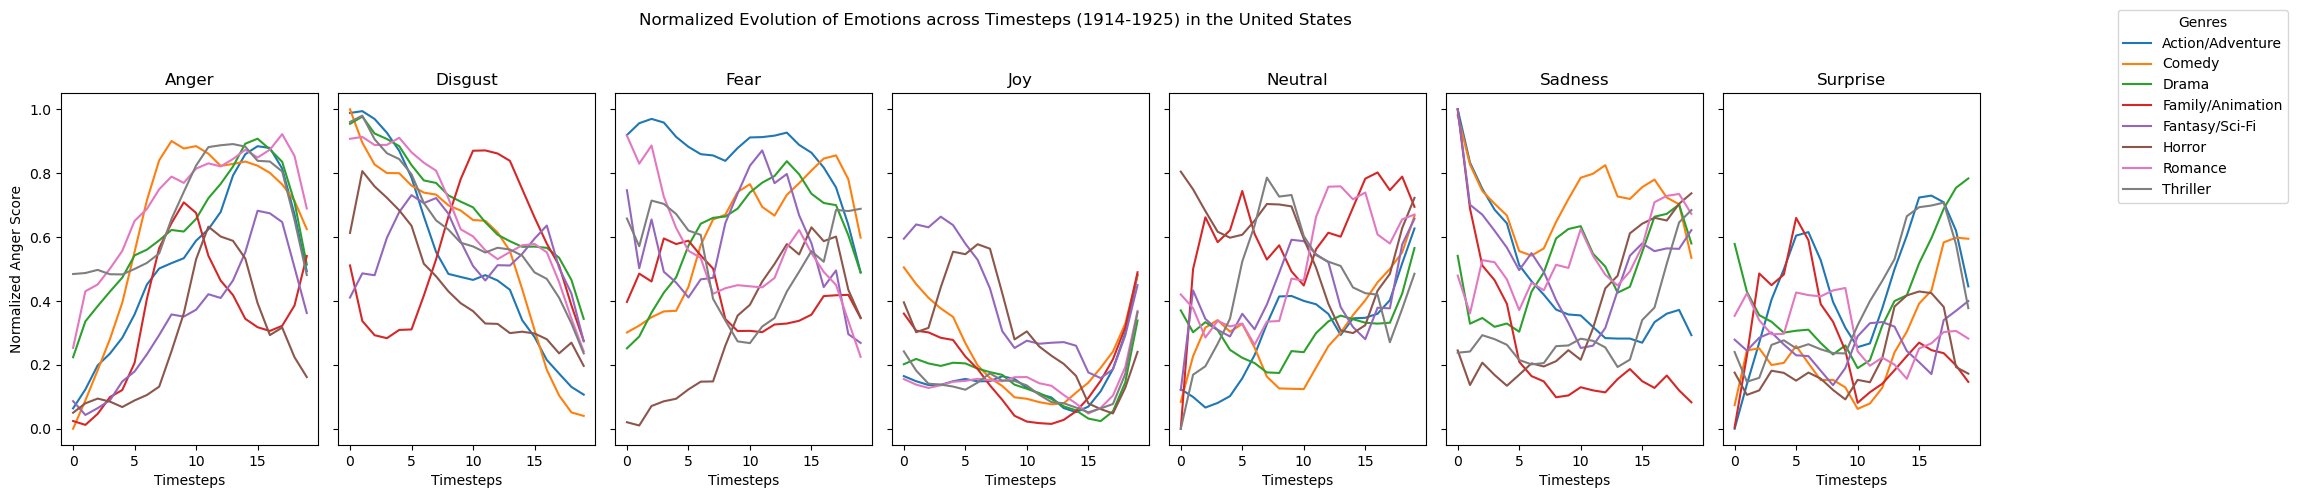

In [23]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1914": df_before_1914,
    "1914-1925": df_1914_1925
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



plus de fear, moins de joy et plus de sadness cste tt le long du film, entre 1914 et 1925 partt dans le monde

## Before and after WW2

In [25]:
df_WW2 = df_merged
#[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_WW2.shape[0]/20)

df_before_1940 = df_usa[
    (df_usa["Movie_release_date"] >= 1930) & 
    (df_usa["Movie_release_date"] <= 1940)
]


# Filter for movies released between 1930 and 1940
df_1940_1950 = df_WW1[
    (df_WW1["Movie_release_date"] >= 1940) & 
    (df_WW1["Movie_release_date"] <= 1950)
]

count_df_before_1940 = df_WW1[df_WW1["Movie_release_date"] < 1940].shape[0]
count_df_1940_1945 = df_WW1[(df_WW1["Movie_release_date"] >= 1940) & (df_WW1["Movie_release_date"] <= 1950)].shape[0]

print(f"Raw count of movies before 1914: {count_df_before_1940/20}")
print(f"Raw count of movies between 1914 and 1925: {count_df_1940_1945/20}")

df_before_1940 = df_before_1940.explode("category")
df_1940_1950 = df_1940_1950.explode("category")

df_before_1940 = df_before_1940.groupby(["category", "timestep"])[emotion_columns].mean()
df_1940_1950 = df_1940_1950.groupby(["category", "timestep"])[emotion_columns].mean()

34342.0
Raw count of movies before 1914: 1991.0
Raw count of movies between 1914 and 1925: 1294.0


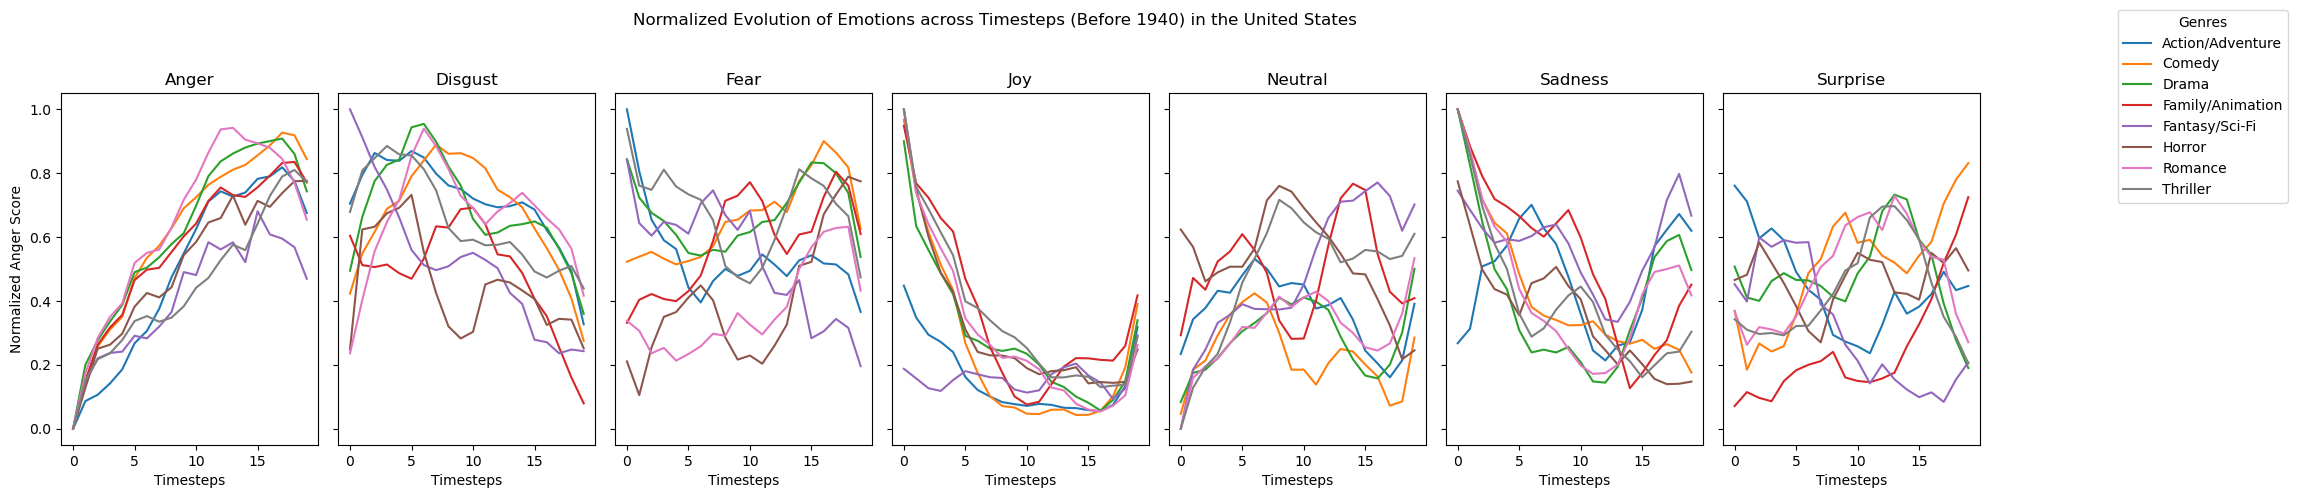

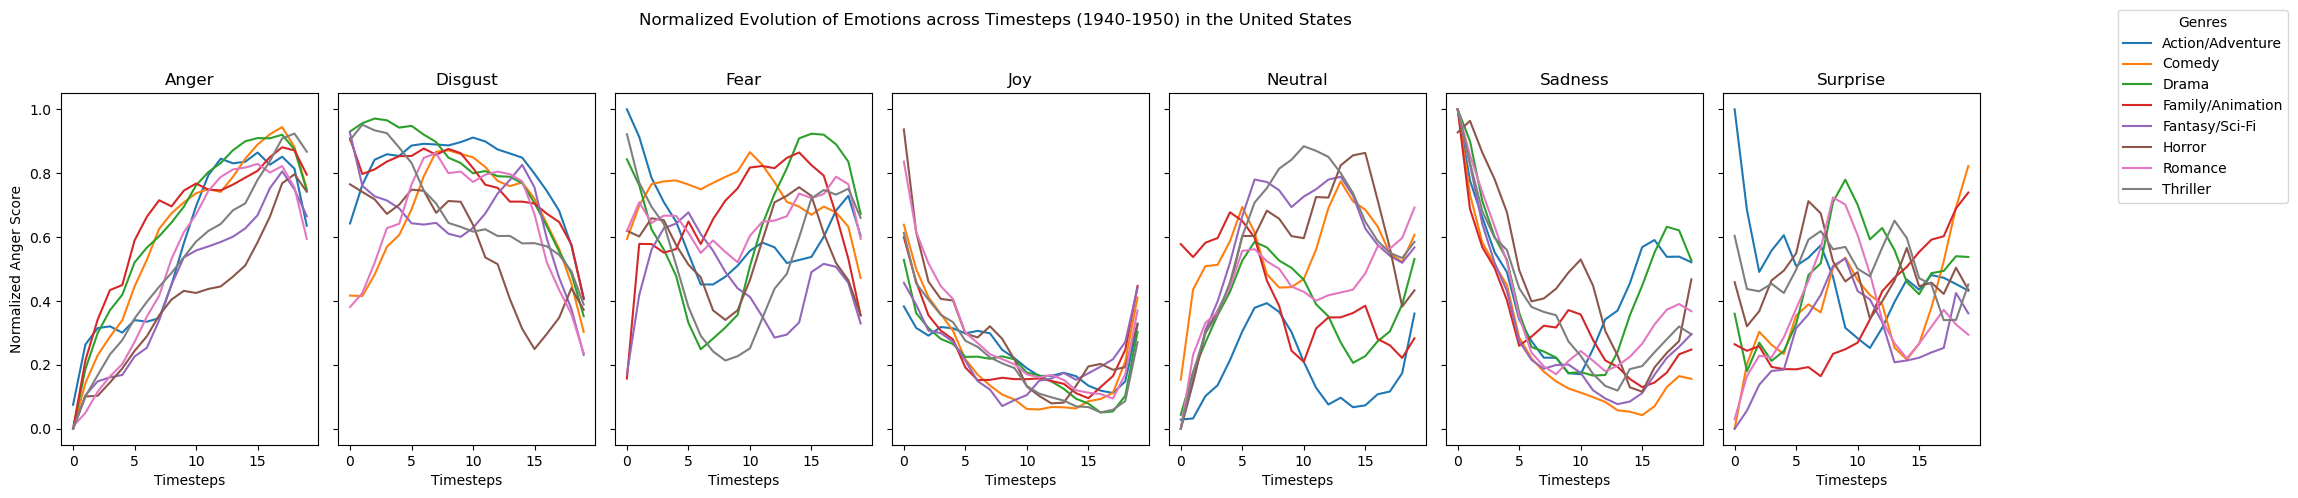

In [26]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 1940": df_before_1940,
    "1940-1950": df_1940_1950
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



pas bcp de changement

## Impact 9/11

In [ ]:
df_911 = df_merged[df_merged["Movie_countries"].str.contains("United States of America", na=False)]
print(df_911.shape[0]/20)

df_before_911 = df_usa[
    (df_usa["Movie_release_date"] >= 1990) & 
    (df_usa["Movie_release_date"] <= 2000)
]


# Filter for movies released between 1930 and 1940
df_after_911 = df_WW1[
    (df_WW1["Movie_release_date"] >= 2001) & 
    (df_WW1["Movie_release_date"] <= 2008)
]

# count_df_before_1940 = df_WW1[df_WW1["Movie_release_date"] < 19.shape[0]
# count_df_1940_1945 = df_WW1[(df_WW1["Movie_release_date"] >= 1940) & (df_WW1["Movie_release_date"] <= 1950)].shape[0]

# print(f"Raw count of movies before 1914: {count_df_before_1940/20}")
# print(f"Raw count of movies between 1914 and 1925: {count_df_1940_1945/20}")

df_before_911 = df_before_911.explode("category")
df_after_911 = df_after_911.explode("category")

df_before_911 = df_before_911.groupby(["category", "timestep"])[emotion_columns].mean()
df_after_911 = df_after_911.groupby(["category", "timestep"])[emotion_columns].mean()

anger   disgust      fear       joy   neutral  \
Wikipedia_movie_ID                                                     
11242               0.036531  0.674604  0.123270  0.001944  0.143095   
11242               0.036531  0.674604  0.123270  0.001944  0.143095   
11242               0.036531  0.674604  0.123270  0.001944  0.143095   
11242               0.050817  0.026665  0.019784  0.012616  0.859535   
11242               0.050817  0.026665  0.019784  0.012616  0.859535   
...                      ...       ...       ...       ...       ...   
37373877            0.015265  0.148570  0.114552  0.009460  0.555081   
37373877            0.014070  0.187139  0.126397  0.011102  0.487088   
37373877            0.011060  0.132366  0.085783  0.008578  0.638195   
37373877            0.008050  0.077592  0.045170  0.006053  0.789302   
37373877            0.005040  0.022818  0.004557  0.003528  0.940410   

                     sadness  surprise  timestep  \
Wikipedia_movie_ID                                 
11242               0.013529  0.007028         0   
11242               0.013529  0.007028         0   
11242               0.013529  0.007028         0   
11242               0.011635  0.018947         1   
11242               0.011635  0.018947         1   
...                      ...       ...       ...   
37373877            0.134403  0.022669        15   
37373877            0.170217  0.003987        16   
37373877            0.118761  0.005258        17   
37373877            0.067304  0.006528        18   
37373877            0.015848  0.007799        19   

                                    Movie_countries      continent  \
Wikipedia_movie_ID                                                   
11242               United States of America, Japan  North America   
11242               United States of America, Japan  North America   
11242               United States of America, Japan  North America   
11242               United States of America, Japan  North America   
11242               United States of America, Japan  North America   
...                                             ...            ...   
37373877                   United States of America  North America   
37373877                   United States of America  North America   
37373877                   United States of America  North America   
37373877                   United States of America  North America   
37373877                   United States of America  North America   

                            category  Movie_release_date  
Wikipedia_movie_ID                                        
11242               Action/Adventure              2001.0  
11242               Family/Animation              2001.0  
11242                 Fantasy/Sci-Fi              2001.0  
11242               Action/Adventure              2001.0  
11242               Family/Animation              2001.0  
...                              ...                 ...  
37373877                      Horror              2006.0  
37373877                      Horror              2006.0  
37373877                      Horror              2006.0  
37373877                      Horror              2006.0  
37373877                      Horror              2006.0  

[115200 rows x 12 columns]

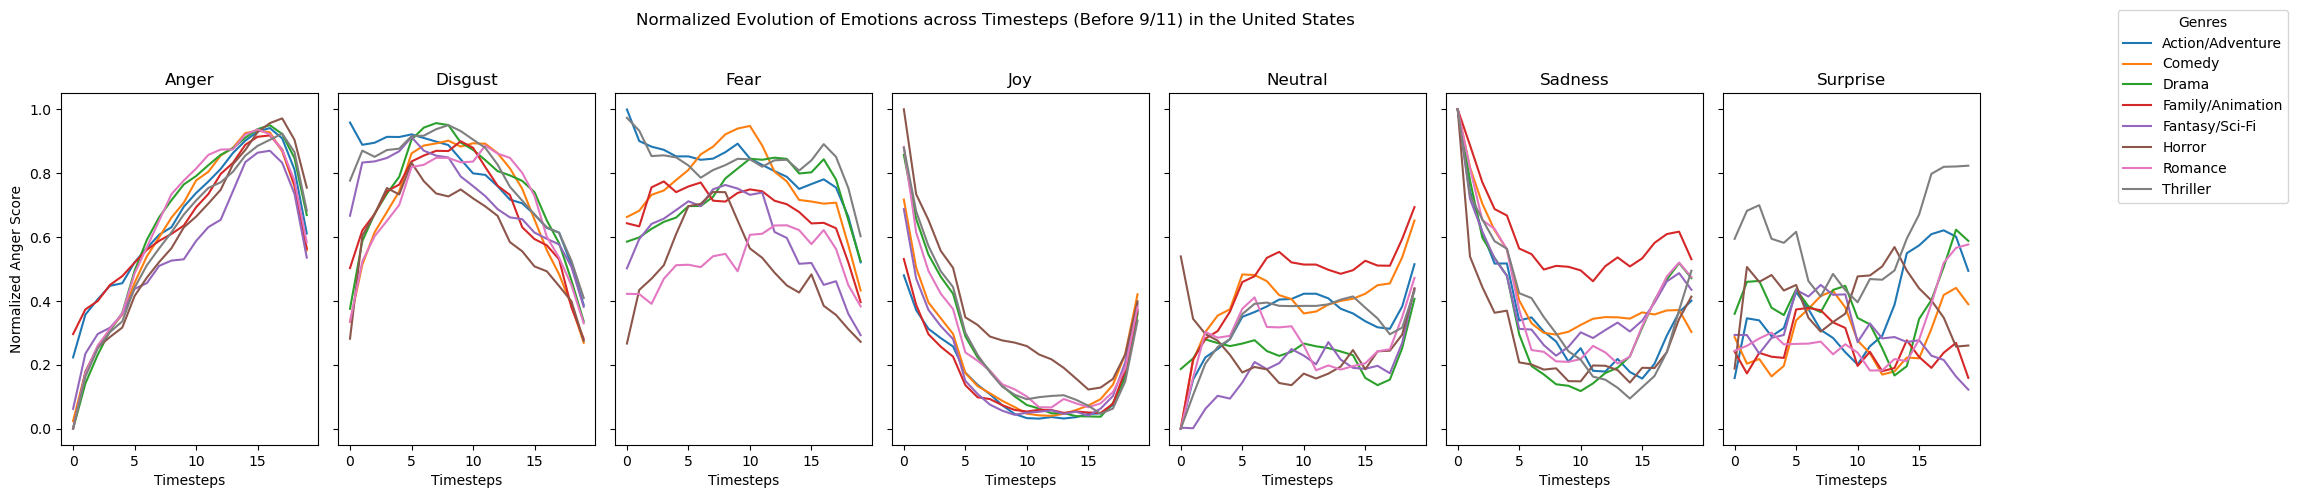

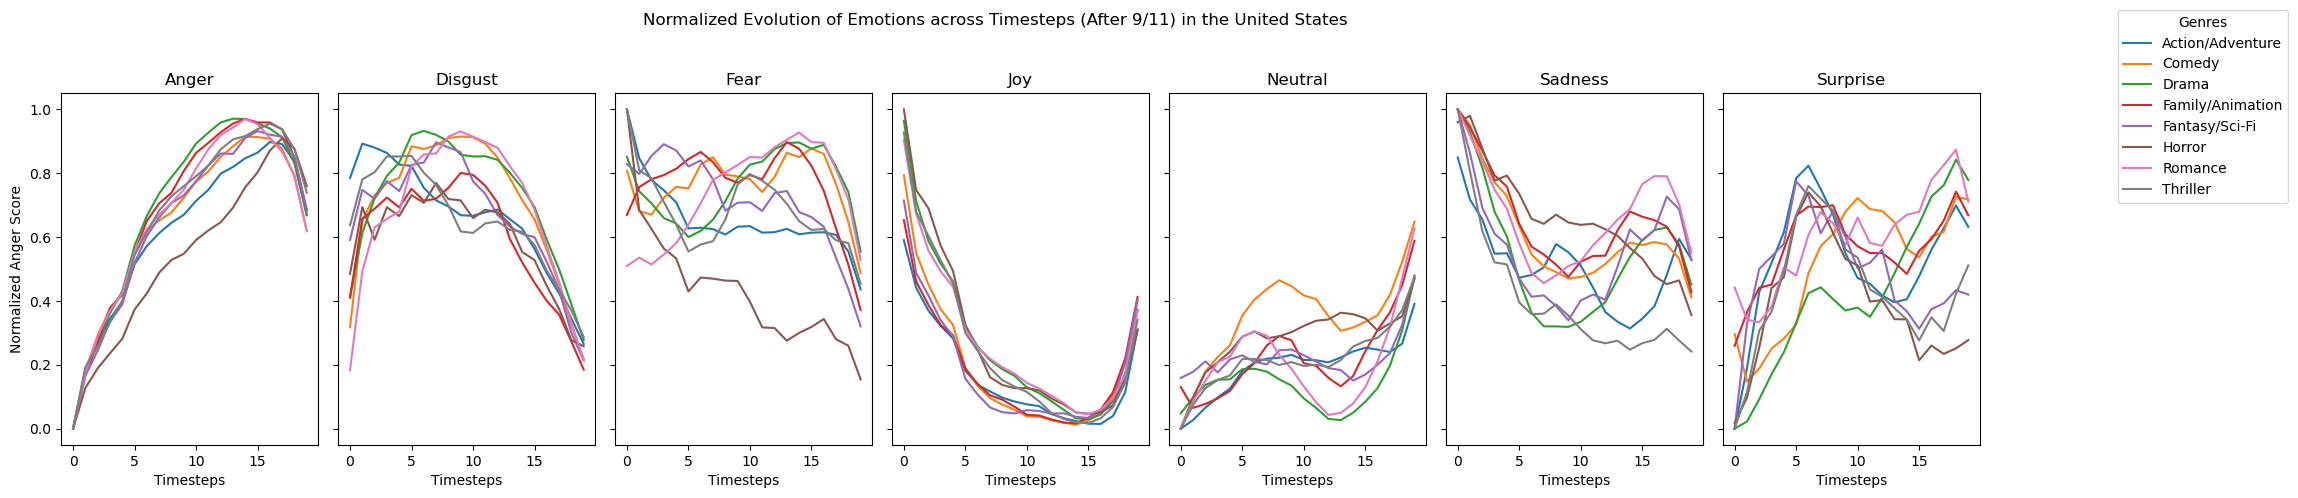

In [30]:
# Define a dictionary to loop over the two periods
datasets = {
    "Before 9/11": df_before_911,
    "After 9/11": df_after_911
}

# Create plots for each dataset
for period_name, df_period in datasets.items():
    fig, axes = plt.subplots(1, 7, figsize=(20, 5), sharex=True, sharey=True)
    fig.suptitle(f"Normalized Evolution of Emotions across Timesteps ({period_name}) in the United States")

    handles = []
    labels = []
    legend_created = False
    window_size = 5

    # Loop over the emotion columns and create subplots
    for ax, emotion in zip(axes, emotion_columns):
        # Reshape the data for the current emotion by genre
        avg_emotion_by_genre = df_period.pivot_table(
            index="timestep", columns="category", values=emotion, aggfunc="mean"
        )

        # Normalize each genre's emotion values (min-max normalization)
        avg_emotion_by_genre = avg_emotion_by_genre.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

        # Apply a rolling mean to smooth the data over the defined window size
        smoothed_avg_emotion_by_genre = avg_emotion_by_genre.rolling(window=window_size, min_periods=1).mean()

        # Use a consistent color palette for genres
        palette = sns.color_palette("tab10", len(smoothed_avg_emotion_by_genre.columns))

        # Plot each genre's emotion evolution on the corresponding subplot
        for jdx, genre in enumerate(smoothed_avg_emotion_by_genre.columns):
            sns.lineplot(
                x=smoothed_avg_emotion_by_genre.index,
                y=smoothed_avg_emotion_by_genre[genre],
                ax=ax,
                label=genre,
                color=palette[jdx]
            )

        # Capture legend handles and labels only once
        if not legend_created:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            legend_created = True

        # Remove the subplot legend to avoid redundancy (it will be added globally later)
        ax.get_legend().remove()

        # Set the title and labels for each subplot
        ax.set_title(emotion.capitalize())
        ax.set_xlabel("Timesteps")
        ax.set_ylabel(f"Normalized {emotion.capitalize()} Score")

    # Add a single legend for all genres, positioned outside the figure
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.15, 1), title="Genres")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



un peu plus de sadness surtt pour les romances a la fin du film, la surpise varie plus au cours du film apres ( du surement au sentimental arc qui devient une recette  bien precise) 

anlayse interreessante, regarder quels films de romances apres 9/11 pour voir si certain sont connu et traite de cet evenement la 